# Imports

In [ ]:
import pandas as pd  
import numpy as np  
import random  

from IPython.display import display

from statsforecast import StatsForecast
from statsforecast.utils import ConformalIntervals  
from utilsforecast.losses import mae  # Mean Absolute Error 

# Forecasting models 
from statsforecast.models import (
    
    # Naive model: Forecasts using the last observed value 
    Naive,
    
    # SeasonalNaive: Forecasts based on the previous season's data
    SeasonalNaive,
    
    # HistoricAverage: Forecasts using the average of all historical data
    HistoricAverage,
    
    # RandomWalkWithDrift: Naive method with a drift component, allowing forecasts to change over time based on the average historical change
    RandomWalkWithDrift,
    
    # CrostonClassic: Designed for intermittent data or data with frequent zeros 
    CrostonClassic as Croston, 
    
    # CrostonOptimized: An optimized version of the Croston method for intermittent demand forecasting
    CrostonOptimized,
    
    # ADIDA: Adaptive combination of different intermittent demand forecasting approaches
    ADIDA,
    
    # IMAPA: Intermittent Multiplicative AutoRegressive Average, a model incorporating autocorrelation for intermittent series
    IMAPA,
    
    # TSB: Forecasts for time series data with many zeros and variable intervals between non-null observations
    TSB,
    
    # ARIMA: Autoregressive Integrated Moving Average, uses past values and lagged forecast errors to predict future values
    ARIMA,
    
    # SeasonalExponentialSmoothing: Forecasts using weighted averages of past values, with more weight given to recent observations
    SeasonalExponentialSmoothing, 
    
    # HoltWinters: Triple exponential smoothing method that accounts for seasonality and trend
    HoltWinters,
    
    # MSTL: Extension of Holt-Winters decomposition for handling multiple seasonal patterns in the data
    MSTL, 
    
    # DynamicOptimizedTheta : Combines exponential smoothing and a linear trend to forecast future values
    DynamicOptimizedTheta as DOT,
    
    # AutoETS: Automated Exponential Smoothing that selects the best model based on AIC (Akaike Information Criterion)
    AutoETS,
    
    # AutoARIMA: Automated ARIMA model that selects the best order and seasonal component
    AutoARIMA,
    
    # AutoTheta: Theta model that automatically detects seasonality
    AutoTheta,
    
    # AutoCES: Automated model that detects seasonality for CES (Cosine Exponential Smoothing)
    AutoCES,

    # AutoMFLES: Automated method for forecasting with Multi-Frequency Local Exponential Smoothing
    AutoMFLES,
)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def evaluate_cv(df, metric):
    """
    Evaluate the best performing models for each time series, scored against a given metric (e.g., Mean Absolute Error).
    
    """
    models = df.columns.drop(['unique_id', 'ds', 'y', 'cutoff']).tolist()
    evals = metric(df, models=models)
    evals['best_model'] = evals[models].idxmin(axis=1)
    return evals

def get_best_model_forecast(forecasts_df, evaluation_df):
    """
    Get the best performing model's forecast for each time series.
    
    """
    with_best = forecasts_df.merge(evaluation_df[['unique_id', 'best_model']])
    res = with_best[['unique_id', 'ds']].copy()
    for suffix in ('', '-lo-80', '-hi-80'):
        res[f'best_model{suffix}'] = with_best.apply(lambda row: row[row['best_model'] + suffix], axis=1)
    return res


# Choose the number of time series

The complete dataset includes 5,000 weekly time series spanning a 4-year period. Adjust the parameter `n` to select the desired data.

In [3]:
n = 5000

In [ ]:
df = pd.read_parquet("data/weekly_time_series.parquet")

selected_uids = np.random.choice(df['unique_id'].unique(), n, replace=False)

df = df[df['unique_id'].isin(selected_uids)]
print(f"Data from {df['ds'].min().date()} to {df['ds'].max().date()} for {df['unique_id'].nunique()} time-series")

df.info()

Data from 2020-07-06 to 2024-04-01 for 5000 time-series
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704732 entries, 0 to 704731
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ds         704732 non-null  datetime64[ns]
 1   y          704732 non-null  float64       
 2   unique_id  704732 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 16.1+ MB


In [5]:
df.head()

,ds,y,unique_id
0,2021-03-29,556.0,P003
1,2021-04-05,973.0,P003
2,2021-04-12,417.0,P003
3,2021-04-19,0.0,P003
4,2021-04-26,457.0,P003


In the plot below, we can observe the weekly units sold for four products. As seen in real-world data, there are periods of no sales (possibly due to lack of inventory) and periods of increased sales (potentially due to ongoing promotions). If we had access to price, promotion, and inventory data, we could better assess the business cycle and incorporate these factors into our model. However, in the absence of such data, we will rely on statistical time series forecasting models to predict demand for each time series.

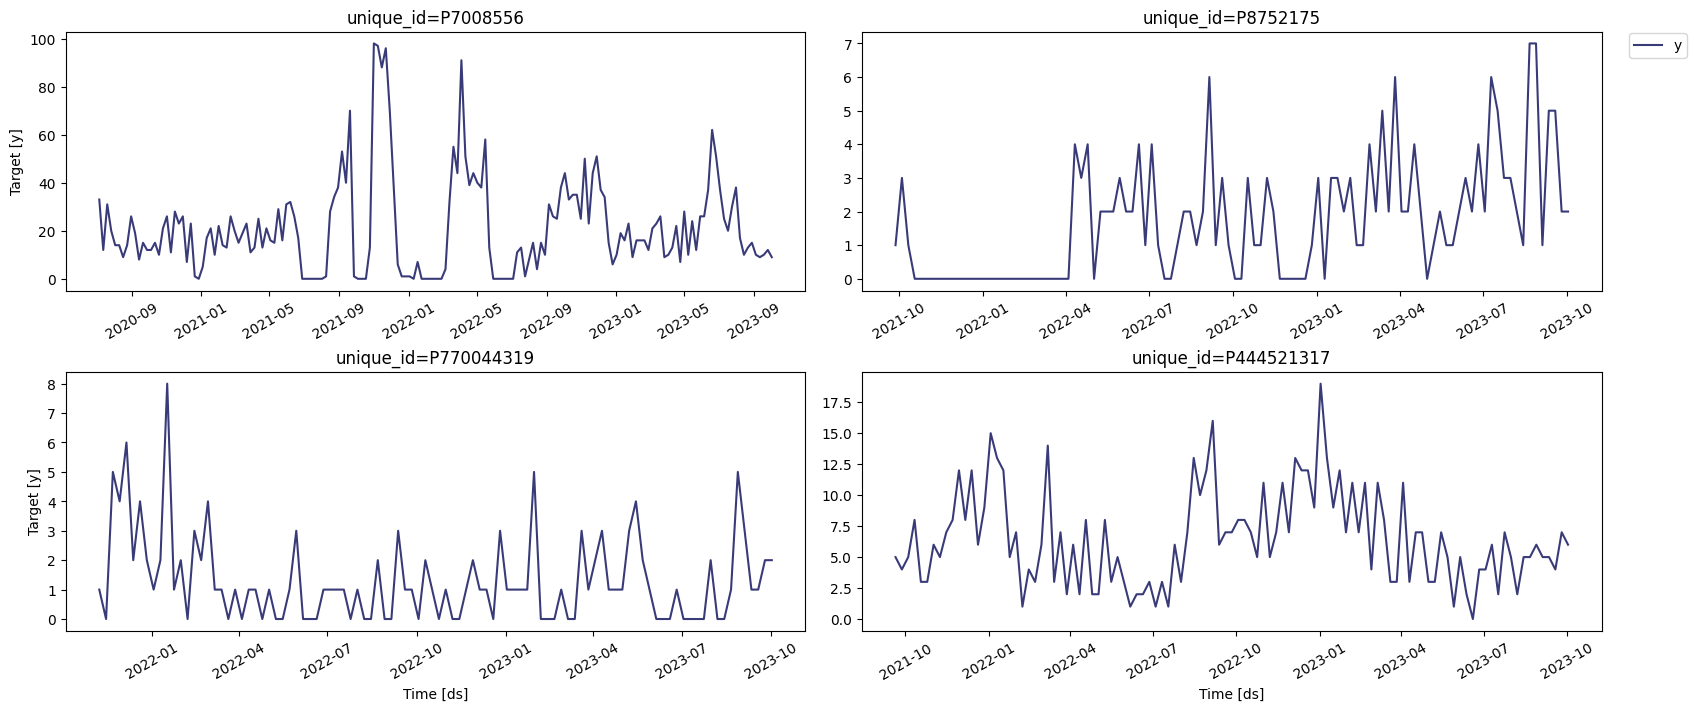

In [6]:
random_uids = random.choices(df['unique_id'].unique(), k=4)
StatsForecast.plot(df, unique_ids=random_uids)

### Forecasting Models

Below is the setup or modeling approach where we use 18 different models to forecast demand. A brief description of each model is provided.

1. **Holt-Winters Method**  
   - A classic approach for forecasting time series with both trend and seasonality. It uses exponential smoothing and is ideal for data that exhibits a clear trend and seasonal patterns.
   - Best suited for forecasting product sales that show consistent seasonal patterns and an overall trend.

2. **Croston Method**  
   - Designed for forecasting intermittent demand, this method is specifically used when sales occur sporadically.
   - Suitable for products with irregular or infrequent sales, such as seasonal or promotional items.

3. **Optimized Croston Method**  
   - An optimized version of the Croston method, which improves forecasting accuracy for intermittent demand by refining the process.
   - Best for products with occasional spikes in sales or unpredictable demand patterns.

4. **Historic Average Method**  
   - A simple forecasting technique that calculates future demand based on the average of historical data points.
   - Useful for products with stable, non-seasonal sales where demand is consistent and predictable.

5. **Dynamic Optimized Theta Method (DOT)**  
   - A method that combines the decomposition of time series with an optimized approach to modeling seasonal patterns and trends.
   - Effective for forecasting products with strong seasonal components and predictable trends, where the model dynamically adjusts to changes in the data.

6. **Seasonal Exponential Smoothing**  
   - A variation of exponential smoothing that accounts for seasonality while also providing prediction intervals for forecasting uncertainty.
   - Best for products with clear seasonal patterns and moderate trends, allowing for accurate predictions based on past behavior.

7. **Aggregate-Dissagregate Intermittent Demand Approach (ADIDA)**  
   - A model designed to forecast intermittent demand by first aggregating and then disaggregating the data to improve prediction accuracy.
   - Suitable for products with irregular sales patterns, offering a method that adapts to sporadic demand.

8. **ARIMA Model**  
   - The Autoregressive Integrated Moving Average (ARIMA) model captures trends and short-term dependencies in time series data.
   - Ideal for products with complex, non-seasonal trends or cyclic behavior, where short-term forecasting is needed.

9. **Multivariate Seasonal-Trend Decomposition using LOESS (MSTL)**  
   - A method that decomposes time series data with multiple seasonal patterns using LOESS (Locally Estimated Scatterplot Smoothing).
   - Best for products that have multiple seasonal influences or changing trends, requiring a more nuanced forecasting approach.

10. **IMAPA Method (Intermittent Multiple Aggregation Prediction Algorithm)**  
    - A method that aggregates data at different levels to improve predictions for intermittent demand.
    - Suitable for products with irregular or infrequent sales, helping to predict demand more accurately in cases of sporadic sales.

11. **Teunter-Syntetos-Babai (TSB) Model**  
    - A model that uses weighted smoothing for both trend and seasonal components, providing predictions with intervals for better uncertainty estimation.
    - Best for products exhibiting both trend and seasonality, capturing variations in sales patterns effectively.

12. **Naive Method**  
    - A basic forecasting approach that assumes future demand will be the same as the most recent observed value.
    - Useful for products with very stable or predictable sales, where a more complex model is unnecessary.

13. **Random Walk with Drift**  
    - A random walk model that includes a drift component, which adjusts forecasts based on historical trends.
    - Suitable for products with a steady, consistent upward or downward sales trend, where future demand follows the same direction.

14. **Multiplicative Functional Linear Exponential Smoothing (MFLES)**  
    - A method that combines linear and exponential smoothing, with a multiplicative component to better capture seasonality.
    - Ideal for products with multiplicative seasonality or cyclic patterns, where sales fluctuate in relation to a base level.

15. **Auto ARIMA Model**  
    - An automatic approach that selects the best ARIMA model for the data, incorporating seasonal adjustments to optimize forecast accuracy.
    - Best suited for products with complex seasonal patterns and varying trends, where model optimization improves forecasting precision.

16. **Auto ETS Model**  
    - Automatically selects the best Exponential Smoothing State Space Model (ETS) by evaluating different models and choosing the most effective one.
    - Suitable for products with clear seasonal and trend patterns, where automatic model selection enhances forecasting accuracy.

17. **Auto Theta Method**  
    - A hybrid forecasting method that combines multiple models and selects the best one for the given data.
    - Best for products with unpredictable sales patterns, using different models to ensure accurate demand forecasting.

18. **Auto CES Model**  
    - A method that automatically selects the most appropriate forecasting technique based on the data’s seasonal components and error structures.
    - Ideal for products with seasonality, where automatic model selection can optimize the forecasting process.

In [7]:
season_length = 12 # 52 weeks in 1 year
intervals = ConformalIntervals(h=4, n_windows=2)

mstl = MSTL(
    season_length=[4, 52/4, 52], # seasonalities of the time series - montlhy, quarterly and annual
    trend_forecaster=AutoARIMA() # model used to forecast trend
)

season_length_mfles = [4, 52/4, 52]
config = {
    'changepoints': [True, False],
    'seasonality_weights': [True, False],
    'smoother': [True, False],
    'ma': [52, 52/4, int(min(season_length_mfles)), int(min(season_length_mfles)/2), None],
    'seasonal_period': [None, season_length_mfles],
    'rs_lr': [.2],
    }
mfles = AutoMFLES(
      season_length = season_length_mfles,
      test_size = 4,
      n_windows=2,
      metric = 'mae', 
      config= config
      )

# Create a list of models and instantiation parameters
models = [
    HoltWinters(),
    Croston(),
    CrostonOptimized(),
    HistoricAverage(),
    DOT(season_length = season_length),
    SeasonalExponentialSmoothing(season_length = season_length, alpha = 0.1, prediction_intervals = intervals),
    ADIDA(prediction_intervals = intervals),
    ARIMA(order = (1,1,1), prediction_intervals = intervals),
    mstl,
    IMAPA(),
    TSB(alpha_d = 0.2, alpha_p = 0.2, prediction_intervals = intervals),
    Naive(),
    RandomWalkWithDrift(),
    mfles,
    AutoARIMA(season_length = season_length), 
    AutoETS(season_length = season_length), 
    AutoTheta(season_length = season_length), 
    AutoCES(season_length = season_length), 
]

# Instantiate StatsForecast class as sf
sf = StatsForecast( 
    models = models,
    freq = 'W', # weekly data frequency
    fallback_model = SeasonalNaive(season_length=season_length),
    n_jobs = 10,
    verbose=False,
)

Next, we perform a time series cross-validation routine using an expanding window. Every 2 weeks, we re-run the forecasting process and predict the next 12 weeks. This process is repeated 4 times to determine the best performing model for each time series in our set. 

We do this to simulate a real-world scenario where new data becomes available over time, and we need to continuously update our forecasts. By using an expanding window, we ensure that each forecast is based on all available data up until that point, allowing the model to improve as more information becomes available. This approach helps us evaluate model performance in a dynamic, time-sensitive setting and identify which model consistently performs the best over time.

In [ ]:
# runtime 70 mins
cv_df = sf.cross_validation(
    df = df,
    h = 12, # forecasts next 12 weeks
    step_size = 2, # re-run the forecasting process every 2 weeks
    n_windows = 4 # evaluate the last 4 runs  
)

# cv_df.head()

/Users/zdhiman/Documents/src/demand/.venv/lib/python3.10/site-packages/statsforecast/arima.py:1867: UserWarning: Stepwise search was stopped early due to reaching the model number limit: nmodels=94
  warnings.warn(


In each cutoff period, we generated a forecast for the next 12 weeks using only the data available up to that point, ensuring that no future data was used and preventing any data leakage.

'Cutoff date: 2023-05-29 00:00:00'

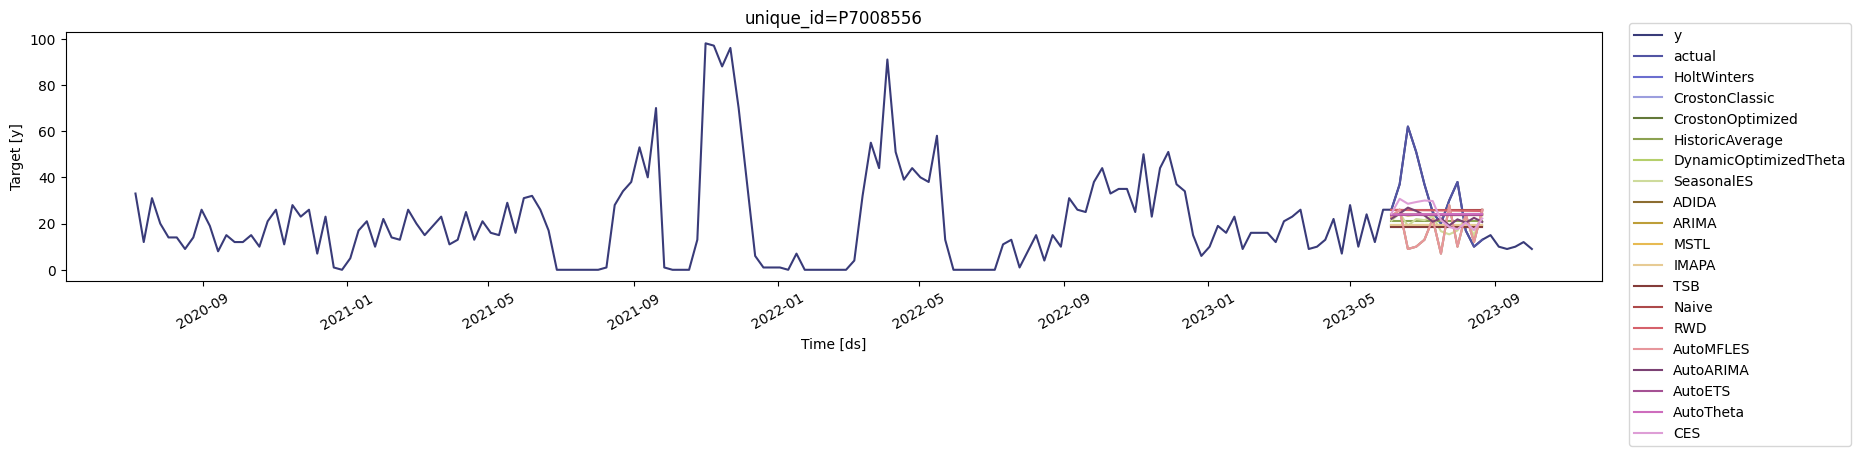

'Cutoff date: 2023-06-12 00:00:00'

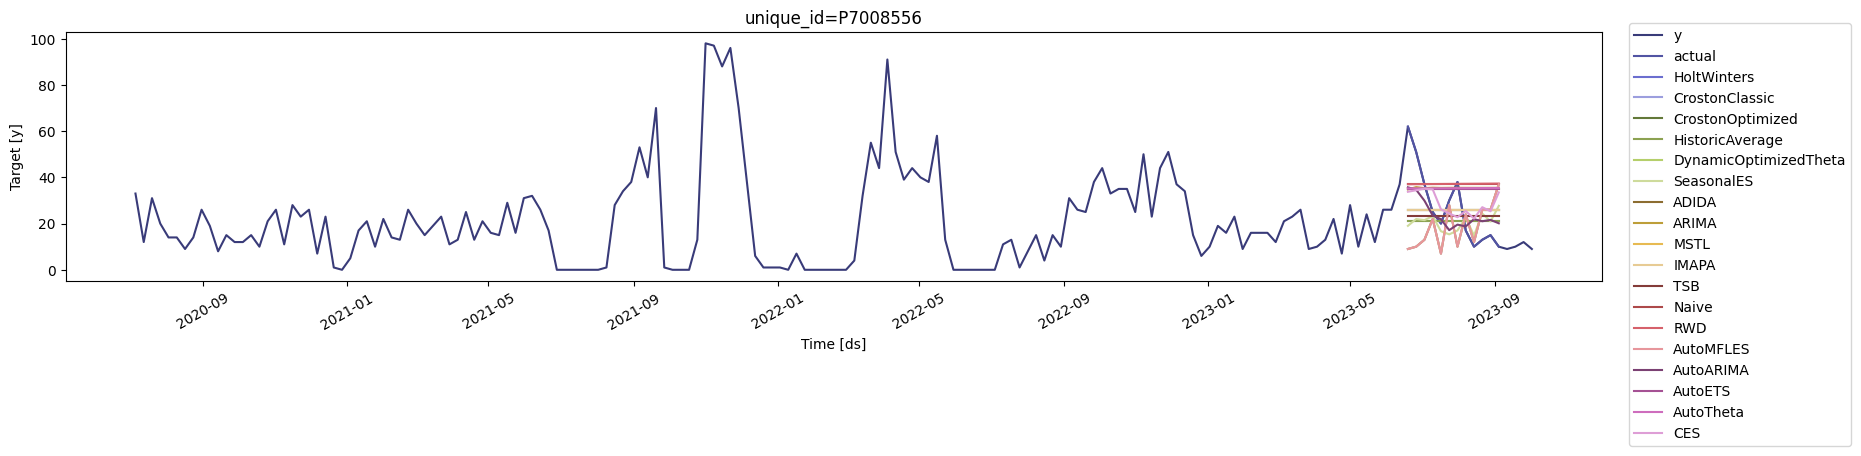

'Cutoff date: 2023-06-26 00:00:00'

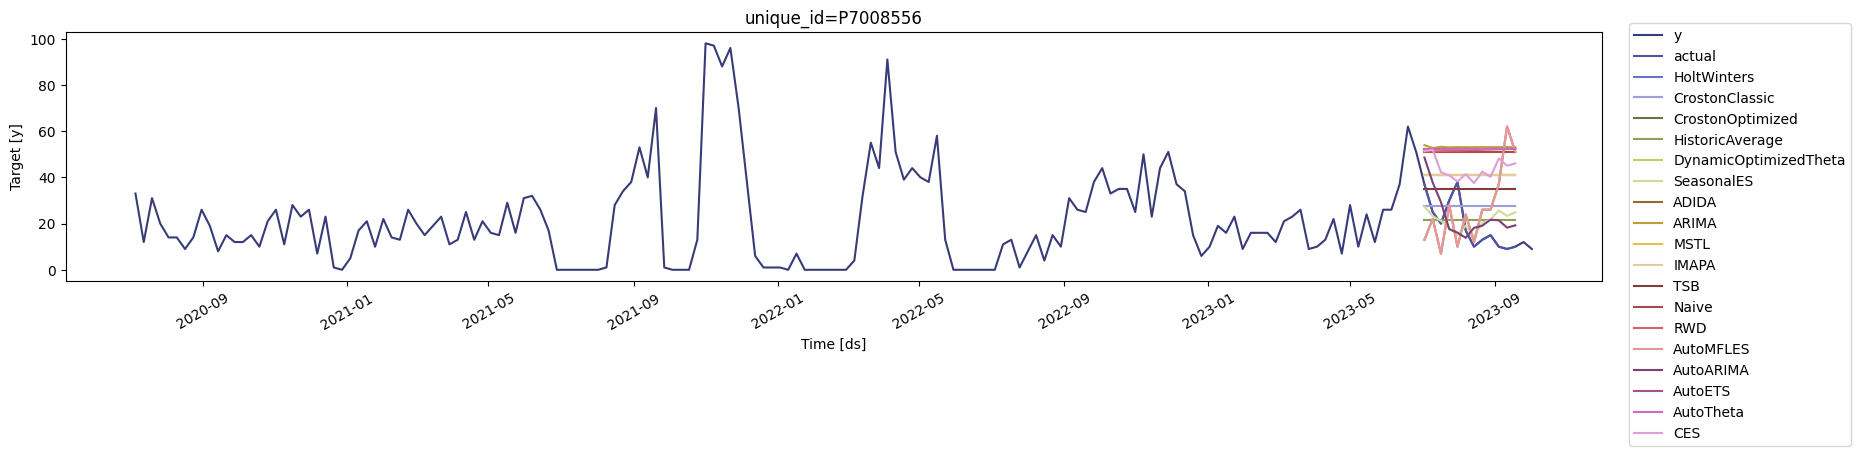

'Cutoff date: 2023-07-10 00:00:00'

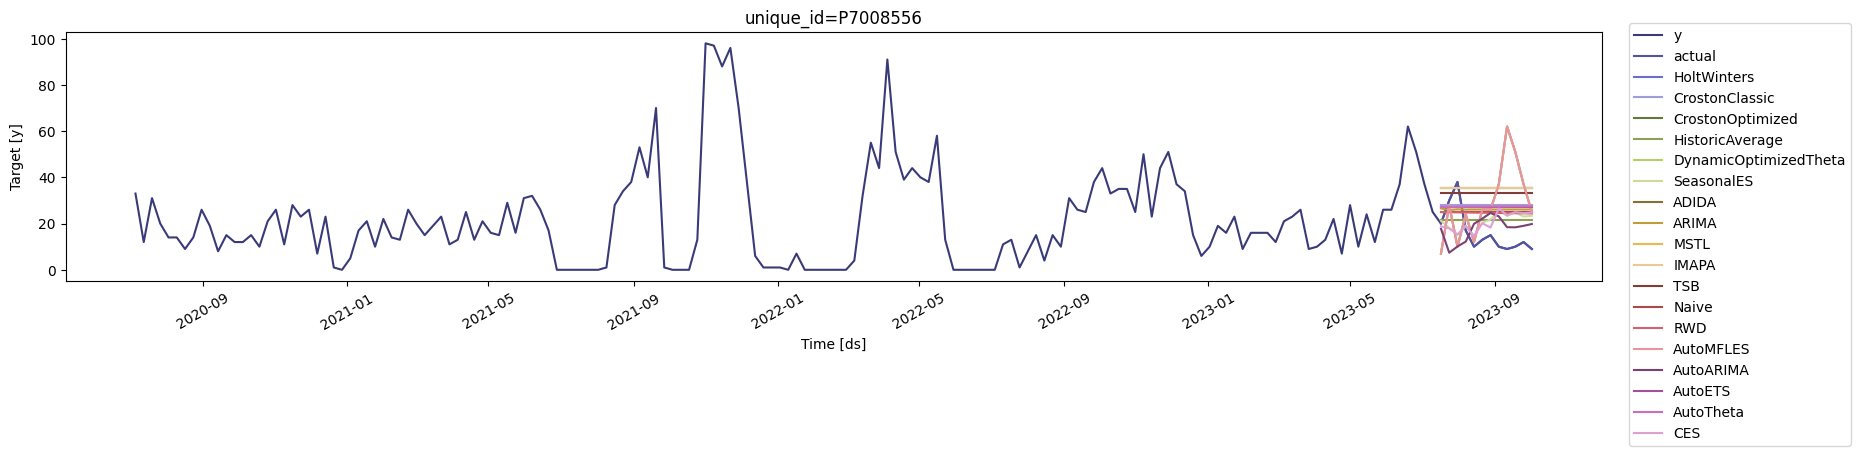

In [ ]:
cv_df.rename(columns = {'y' : 'actual'}, inplace = True) 

cutoff = cv_df['cutoff'].unique()

for k in range(len(cutoff)-4): 
    cv = cv_df[cv_df['cutoff'] == cutoff[k]]
    display(f"Cutoff date: {cutoff[k]}")
    display(StatsForecast.plot(df, cv.loc[:, cv.columns != 'cutoff'], unique_ids=[random_uids[0]]))

The results below display the best performing models evaluated based on Mean Absolute Error, along with the respective number of time series. CrostonClassic is selected for 727 out of the 5000 time series in our dataset, followed by HistoricAverage for 624, and similarly for the other models.

In [10]:
cv_df.rename(columns = {'actual' : 'y'}, inplace = True) 
evaluation_df = evaluate_cv(cv_df, mae)
evaluation_df['best_model'].value_counts().to_frame().reset_index()

,best_model,count
0,CrostonClassic,727
1,HistoricAverage,624
2,HoltWinters,534
3,Naive,519
4,CES,378
5,TSB,352
6,CrostonOptimized,347
7,AutoARIMA,330
8,AutoTheta,277
9,SeasonalES,269


We can also observe the MAE for each model and time series, along with the best model, allowing for a deeper analysis of the results.

In [18]:
df_mae = pd.DataFrame([evaluation_df.unique_id, evaluation_df.best_model, evaluation_df[evaluation_df.columns[evaluation_df.dtypes == 'float64']].min(axis=1)]).T
df_mae.rename(columns={"Unnamed 0": "MAE"}, inplace=True)
df_mae.sample(5)

,unique_id,best_model,MAE
10,P1003240164,AutoARIMA,1.607024
4052,P728222295,Naive,1.5625
3271,P55581257,HoltWinters,1.166667
4942,P944634325,Naive,0.479167
1680,P1424042229,CrostonClassic,1.457005


Finally, we use the results from the cross-validation exercise to assign the best model to each time series and generate future predictions for the next 12 weeks, along with an 80% confidence interval.

In [12]:
forecasts_df = sf.forecast(df=df, h=12, level=[80])

prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)
prod_forecasts_df['best_model-lo-80'] = prod_forecasts_df['best_model-lo-80'].clip(lower=0)

prod_forecasts_df.head()

,unique_id,ds,best_model,best_model-lo-80,best_model-hi-80
0,P003,2023-10-08,26.0,0.0,202.623077
1,P003,2023-10-15,29.0,0.0,205.623077
2,P003,2023-10-22,25.0,0.0,201.623077
3,P003,2023-10-29,14.0,0.0,190.623077
4,P003,2023-11-05,17.0,0.0,193.623077


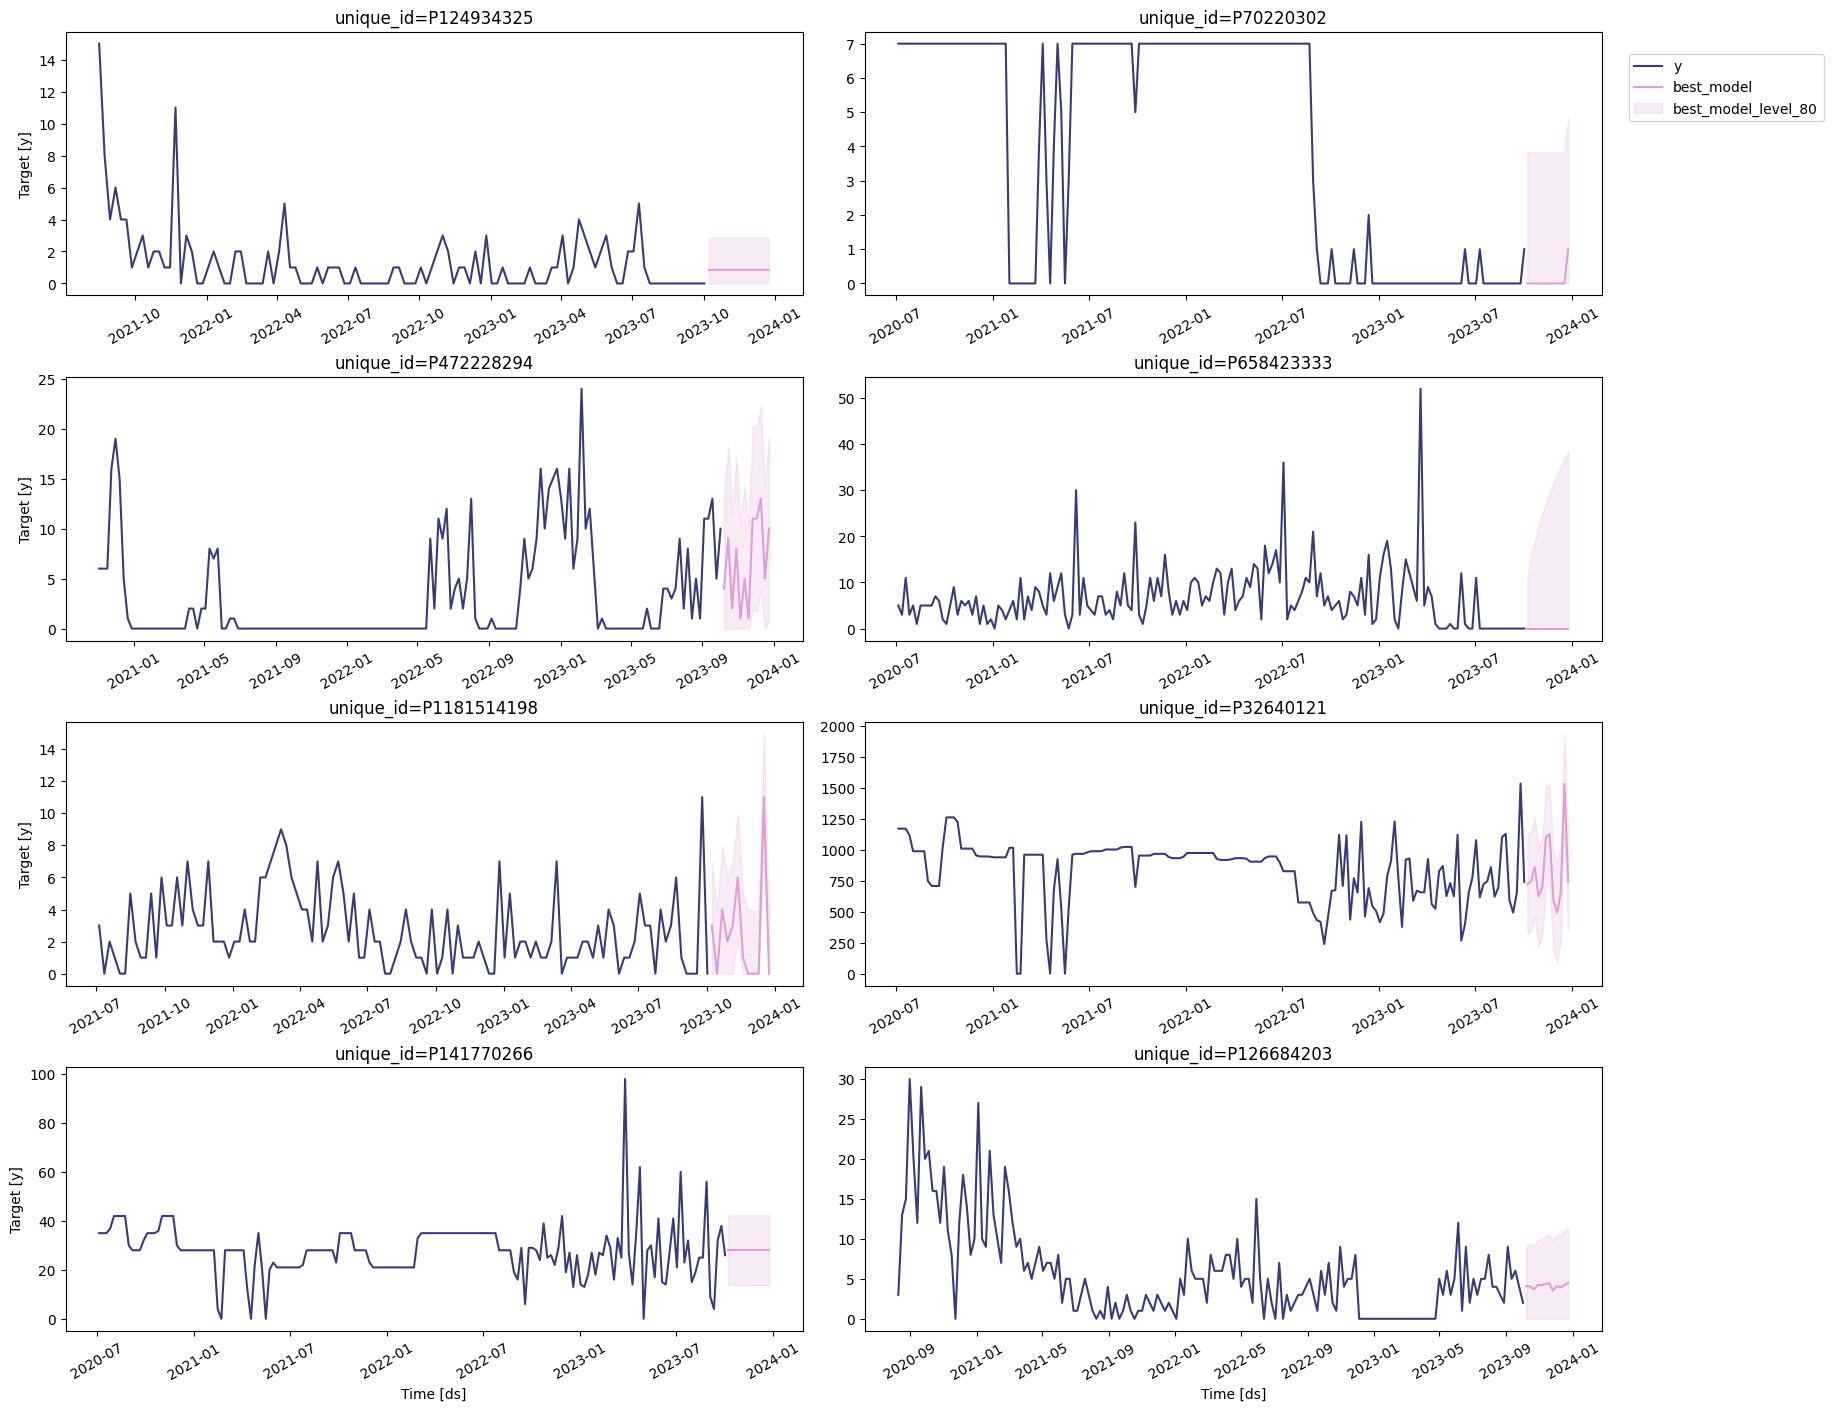

In [13]:
sf.plot(df, prod_forecasts_df, level=[80], unique_ids=np.random.choice(selected_uids, 10, replace=False))

This workflow demonstrates a dynamic and adaptable approach to tackling the time series demand forecasting problem in a real-world use case. The approach is designed to be flexible and scalable, allowing for the introduction of new models to the model set as needed, thereby enhancing the forecasting accuracy. Additionally, by expanding the cross-validation window parameter, we can build a more robust model that better captures longer-term trends and fluctuations. As new data becomes available, this methodology continuously adapts, selecting the best-fitting model that reflects any changes in the underlying trend, seasonality, or business cycle. This ensures that the forecasting model remains relevant and precise, even in the face of shifting patterns in demand over time.